In [2]:
# General
from __future__ import unicode_literals

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# To avoid Type3 fonts in generated pdf file
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Logger
import logging
logging.basicConfig(level=logging.WARN)

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS module
from lcs.agents.acs2 import ACS2, Configuration, ClassifiersList

# Load environments
import gym
import gym_maze

### Environment - Maze

We are going to look at provided mazes. Their names starts with “Maze…” or “Woods…” so see what is possible to load :

In [3]:
# Custom function for obtaining available environments
filter_envs = lambda env: env.id.startswith("Maze") or env.id.startswith("Woods") or env.id.startswith("Test") or env.id.startswith("Littman") or env.id.startswith("Miyazaki")

all_envs = [env for env in gym.envs.registry.all()]
maze_envs = [env for env in all_envs if filter_envs(env)]

for env in maze_envs:
    print("Maze ID: [{}], non-deterministic: [{}], trials: [{}]".format(
            env.id, env.nondeterministic, env.trials))

Maze ID: [MazeF1-v0], non-deterministic: [False], trials: [100]
Maze ID: [MazeF2-v0], non-deterministic: [False], trials: [100]
Maze ID: [MazeF3-v0], non-deterministic: [False], trials: [100]
Maze ID: [MazeF4-v0], non-deterministic: [True], trials: [100]
Maze ID: [Maze4-v0], non-deterministic: [False], trials: [100]
Maze ID: [Maze5-v0], non-deterministic: [False], trials: [100]
Maze ID: [Maze6-v0], non-deterministic: [True], trials: [100]
Maze ID: [Woods1-v0], non-deterministic: [False], trials: [100]
Maze ID: [Woods14-v0], non-deterministic: [False], trials: [100]
Maze ID: [TestMaze-v0], non-deterministic: [False], trials: [100]
Maze ID: [Littman57-v0], non-deterministic: [False], trials: [100]
Maze ID: [Maze7-v0], non-deterministic: [False], trials: [100]
Maze ID: [Maze10-v0], non-deterministic: [False], trials: [100]
Maze ID: [MazeE1-v0], non-deterministic: [False], trials: [100]
Maze ID: [MazeE2-v0], non-deterministic: [False], trials: [100]
Maze ID: [MiyazakiA-v0], non-determinist

Let’s see how it looks in action. First we are going to initialize new environment using gym.make() instruction from OpenAI Gym.

In [4]:
MAZE = "Woods14-v0"

# Initialize environment
maze = gym.make(MAZE)

# Reset it, by putting an agent into random position
situation = maze.reset()

# Render the state in ASCII
maze.render()


■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ ■ □ □ □ ■ ■ ■ ■ □ ■ ■ □ ■
■ □ ■ ■ ■ □ ■ ■ □ ■ □ ■ □ ■
■ □ ■ ■ ■ □ ■ □ ■ ■ ■ □ ■ ■
■ $ ■ ■ ■ A ■ ■ □ ■ ■ ■ ■ ■
■ ■ ■ ■ ■ ■ □ □ ■ ■ ■ ■ ■ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■


The reset() function puts an agent into random position (on path inside maze) returning current perception.

The perception consists of 8 values representing N, NE, E, SE, S, SW, W, NW directions. 

It outputs 0 for the path, 1 for the wall and 9 for the reward.

In [5]:
# Show current agents perception
situation

('0', '1', '1', '0', '1', '1', '1', '1')

We can interact with the environment by performing actions.

Agent can perform 8 actions - moving into different directions.

To do so use step(action) function. It will return couple interesting information: 

    - new state percepton, 
    - reward for executing move (ie. finding the reward) 
    - is the trial finish, 
    - debug data

In [6]:
ACTION = 0 # Move N

# Execute action
state, reward, done, _ = maze.step(ACTION)

# Show new state
print(f"New state: {state}, reward: {reward}, is done: {done}")

# Render the env one more time after executing step
maze.render()

New state: ('0', '1', '1', '1', '0', '1', '1', '1'), reward: 0, is done: False

■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
■ ■ □ □ □ ■ ■ ■ ■ □ ■ ■ □ ■
■ □ ■ ■ ■ □ ■ ■ □ ■ □ ■ □ ■
■ □ ■ ■ ■ A ■ □ ■ ■ ■ □ ■ ■
■ $ ■ ■ ■ □ ■ ■ □ ■ ■ ■ ■ ■
■ ■ ■ ■ ■ ■ □ □ ■ ■ ■ ■ ■ ■
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■


### Agent - ACS2

First provide a helper method for calculating obtained knowledge

In [7]:
def _maze_knowledge(population, environment) -> float:
    transitions = environment.env.get_all_possible_transitions()

    # Take into consideration only reliable classifiers
    reliable_classifiers = [c for c in population if c.is_reliable()]

    # Count how many transitions are anticipated correctly
    nr_correct = 0

    # For all possible destinations from each path cell
    for start, action, end in transitions:

        p0 = environment.env.maze.perception(*start)
        p1 = environment.env.maze.perception(*end)

        if any([True for cl in reliable_classifiers
                if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1

    return nr_correct / len(transitions) * 100.0

In [8]:
from lcs.metrics import population_metrics

def _maze_metrics(pop, env):
    metrics = {
        'knowledge': _maze_knowledge(pop, env)
    }

    # Add basic population metrics
    metrics.update(population_metrics(pop, env))

    return metrics

### Exploration phase

In [9]:
CLASSIFIER_LENGTH=8
NUMBER_OF_POSSIBLE_ACTIONS=8

# Define agent's default configuration
cfg = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=False,
    do_subsumption=True,
    do_action_planning=False,
    action_planning_frequency=50,
    beta=0.05,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.5,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8
)

# Define agent
agent = ACS2(cfg)

In [10]:
%%time
population, metrics = agent.explore(maze, 1000)

CPU times: user 51.1 s, sys: 290 ms, total: 51.4 s
Wall time: 52.2 s


We can take a sneak peek into a created list of classifiers. Let’s have a look at top 10:

In [11]:
population.sort(key=lambda cl: -cl.fitness)

for cl in population[:100]:
    #print("{!r} \tq: {:.2f} \tr: {:.2f} \tir: {:.2f}".format(cl, cl.q, cl.r, cl.ir))
    print("{!r} \t {!r} \t {!r} \t {:.3f} \t {!r}".format(cl.condition, cl.action, cl.effect, cl.fitness, cl.mark))

####9### 	 4 	 ####1### 	 1000.000 	 empty
10##0### 	 4 	 01##9### 	 950.000 	 empty
#10#10## 	 5 	 #01#01## 	 902.500 	 empty
#10#10#1 	 5 	 #01#01## 	 902.500 	 empty
01##9### 	 0 	 10##0### 	 902.500 	 empty
#0##0### 	 3 	 ######## 	 902.496 	 empty
1###0#1# 	 3 	 ######## 	 857.913 	 empty
#1#1#10# 	 6 	 #####01# 	 857.375 	 empty
##0##10# 	 6 	 #####01# 	 857.375 	 empty
#10##10# 	 6 	 #####01# 	 857.375 	 empty
##01#10# 	 6 	 #####01# 	 857.375 	 empty
#01#01## 	 1 	 #10#10## 	 857.339 	 empty
####0##1 	 2 	 ######## 	 837.713 	 empty
##10##0# 	 6 	 ##01#### 	 814.506 	 empty
#110##0# 	 6 	 ##01#### 	 814.506 	 empty
1#10##0# 	 6 	 ##01#### 	 814.506 	 empty
1110##0# 	 6 	 ##01#### 	 814.506 	 empty
##0##01# 	 2 	 #####10# 	 814.503 	 empty
##0##011 	 2 	 #####10# 	 814.503 	 empty
####0### 	 3 	 ######## 	 808.902 	 empty
####0##1 	 5 	 ######## 	 805.157 	 empty
####0### 	 2 	 ######## 	 804.634 	 empty
0####### 	 2 	 ######## 	 796.060 	 empty
0######1 	 2 	 ######## 	 796.060

### Exploitation

Now we can either reuse our previous agent or initialize it one more time passing the initial population of classifiers as apriori knowledge.

In [12]:
# Reinitialize agent using defined configuration and population
agent = ACS2(cfg, population)

In [13]:
%%time
population, metrics = agent.exploit(maze, 1)

CPU times: user 26.2 ms, sys: 929 µs, total: 27.2 ms
Wall time: 26.4 ms


In [14]:
metrics[-1]

{'trial': 0,
 'steps_in_trial': 10,
 'reward': 1000,
 'knowledge': 100.0,
 'population': 133,
 'numerosity': 133,
 'reliable': 133}

### Experiments

In [15]:
def parse_metrics_to_df(explore_metrics, exploit_metrics):
    def extract_details(row):
        row['trial'] = row['trial']
        row['steps'] = row['steps_in_trial']
        row['numerosity'] = row['numerosity']
        row['reliable'] = row['reliable']
        row['knowledge'] = row['knowledge']
        return row

    # Load both metrics into data frame
    explore_df = pd.DataFrame(explore_metrics)
    exploit_df = pd.DataFrame(exploit_metrics)

    # Mark them with specific phase
    explore_df['phase'] = 'explore'
    exploit_df['phase'] = 'exploit'

    # Extract details
    explore_df = explore_df.apply(extract_details, axis=1)
    exploit_df = exploit_df.apply(extract_details, axis=1)

    # Adjuts exploit trial counter
    exploit_df['trial'] = exploit_df.apply(lambda r: r['trial']+len(explore_df), axis=1)

    # Concatenate both dataframes
    df = pd.concat([explore_df, exploit_df])
    df.set_index('trial', inplace=True)

    return df

For various mazes visualize - classifiers / reliable classifiers for steps - optimal policy - steps (exploration | exploitation) - knowledge - parameters setting

In [16]:
def find_best_classifier(population, situation, cfg):
    match_set = population.form_match_set(situation)
    anticipated_change_cls = [cl for cl in match_set if cl.does_anticipate_change()]

    if (len(anticipated_change_cls) > 0):
        return max(anticipated_change_cls, key=lambda cl: cl.fitness)

    return None

def build_fitness_matrix(env, population, cfg):
    original = env.env.maze.matrix
    fitness = original.copy()

    # Think about more 'functional' way of doing this
    for index, x in np.ndenumerate(original):
        # Path - best classfier fitness
        if x == 0:
            perception = env.env.maze.perception(index[1], index[0])
            best_cl = find_best_classifier(population, perception, cfg)
            if best_cl:
                fitness[index] = best_cl.fitness
            else:
                fitness[index] = -1

        # Wall - fitness = 0
        if x == 1:
            fitness[index] = 0

        # Reward - inf fitness
        if x == 9:
            fitness[index] = fitness.max () + 500

    return fitness

def build_action_matrix(env, population, cfg):
    ACTION_LOOKUP = {
        0: u'↑', 1: u'↗', 2: u'→', 3: u'↘',
        4: u'↓', 5: u'↙', 6: u'←', 7: u'↖'
    }

    original = env.env.maze.matrix
    action = original.copy().astype(str)

    # Think about more 'functional' way of doing this
    for index, x in np.ndenumerate(original):
        # Path - best classfier fitness
        if x == 0:
            perception = env.env.maze.perception(index[1], index[0])
            best_cl = find_best_classifier(population, perception, cfg)
            if best_cl:
                action[index] = ACTION_LOOKUP[best_cl.action]
            else:
                action[index] = '?'

        # Wall - fitness = 0
        if x == 1:
            action[index] = '\#'

        # Reward - inf fitness
        if x == 9:
            action[index] = 'R'

    return action

### Plotting functions and settings

In [17]:
# Plot constants
TITLE_TEXT_SIZE=18
AXIS_TEXT_SIZE=12
LEGEND_TEXT_SIZE=14

In [18]:
def plot_policy(env, agent, cfg, ax=None):
    if ax is None:
        ax = plt.gca()

    ax.set_aspect("equal")

    # Handy variables
    maze_countours = maze.env.maze.matrix
    max_x = env.env.maze.max_x
    max_y = env.env.maze.max_y

    fitness_matrix = build_fitness_matrix(env, agent.population, cfg)
    action_matrix = build_action_matrix(env, agent.population, cfg)

    # Render maze as image
    plt.imshow(fitness_matrix, interpolation='nearest', cmap='Reds', aspect='auto',
           extent=[0, max_x, max_y, 0])


    # Add labels to each cell
    for (y,x), val in np.ndenumerate(action_matrix):
        plt.text(x+0.4, y+0.5, "${}$".format(val))

    ax.set_title("Policy", fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel('x', fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel('y', fontsize=AXIS_TEXT_SIZE)

    ax.set_xlim(0, max_x)
    ax.set_ylim(1+max_y, 0)

    ax.set_xticks(range(0, max_x+1))
    ax.set_yticks(range(0, max_y+1))

    ax.grid(True)

In [19]:
def plot_knowledge(df, ax=None):
    if ax is None:
        ax = plt.gca()

    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")

    explore_df['knowledge'].plot(ax=ax, c='blue')
    exploit_df['knowledge'].plot(ax=ax, c='red')
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')

    ax.set_title("Achieved knowledge", fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel("Trial", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel("Knowledge [%]", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylim([0, 105])

In [20]:
def plot_steps(df, ax=None):
    if ax is None:
        ax = plt.gca()

    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")

    explore_df['steps'].plot(ax=ax, c='blue', linewidth=.5)
    exploit_df['steps'].plot(ax=ax, c='red', linewidth=0.5)
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')

    ax.set_title("Steps", fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel("Trial", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel("Steps", fontsize=AXIS_TEXT_SIZE)

In [21]:
def plot_classifiers(df, ax=None):
    if ax is None:
        ax = plt.gca()

    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")

    df['numerosity'].plot(ax=ax, c='blue')
    df['reliable'].plot(ax=ax, c='red')

    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')

    ax.set_title("Classifiers", fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel("Trial", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel("Classifiers", fontsize=AXIS_TEXT_SIZE)
    ax.legend(fontsize=LEGEND_TEXT_SIZE)

In [22]:
def plot_performance(agent, maze, metrics_df, cfg, env_name):
    plt.figure(figsize=(13, 10), dpi=100)
    plt.suptitle(f'ACS2 Performance in {env_name} environment', fontsize=32)

    ax1 = plt.subplot(221)
    plot_policy(maze, agent, cfg, ax1)

    ax2 = plt.subplot(222)
    plot_knowledge(metrics_df, ax2)

    ax3 = plt.subplot(223)
    plot_classifiers(metrics_df, ax3)

    ax4 = plt.subplot(224)
    plot_steps(metrics_df, ax4)

    plt.subplots_adjust(top=0.86, wspace=0.3, hspace=0.3)

### TestMaze

CPU times: user 3min 24s, sys: 1.38 s, total: 3min 25s
Wall time: 3min 30s


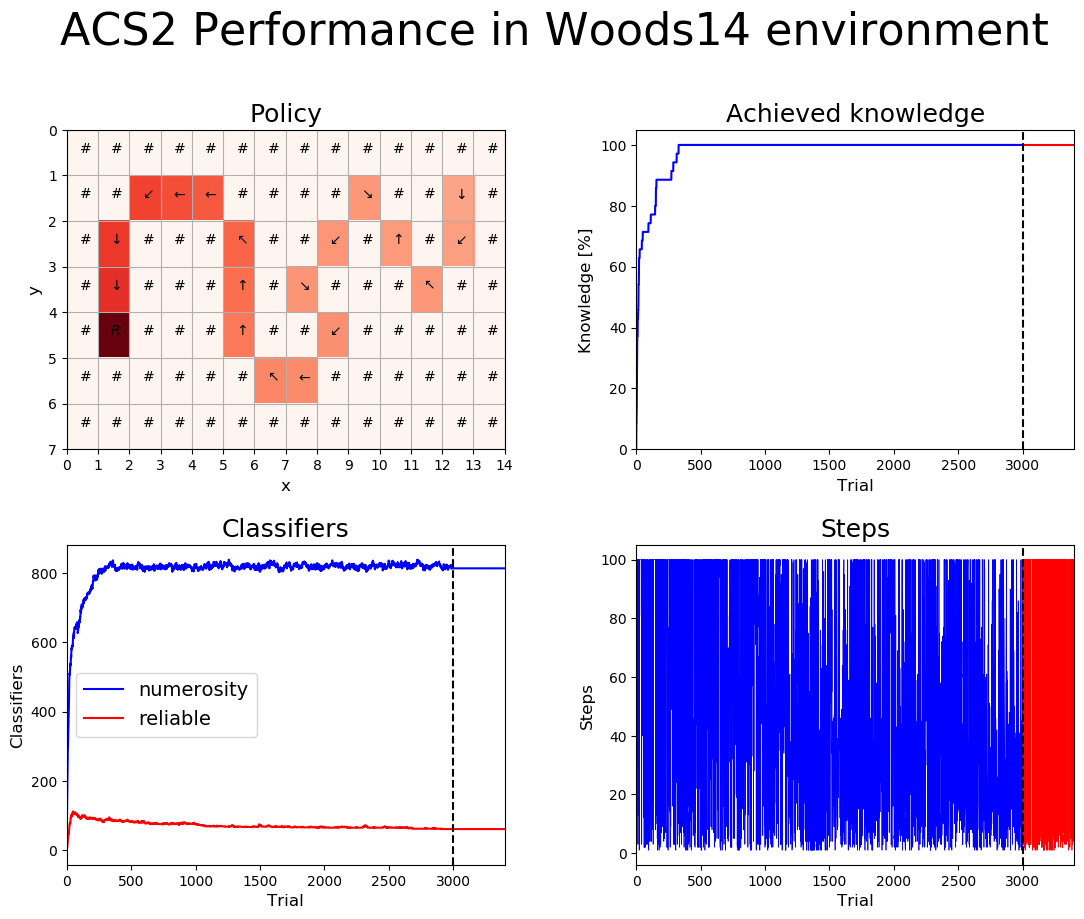

In [25]:
%%time

# Define agent's default configuration
cfg = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=True,
    do_subsumption=True,
    do_action_planning=False,
    action_planning_frequency=50,
    beta=0.05,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.5,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8
)

# Get the accurate environment
# define environment
testMaze = gym.make('Woods14-v0')

# explore
agent_testMaze = ACS2(cfg)
population_testMaze_explore, metrics_testMaze_explore = agent_testMaze.explore(testMaze, 3000)

# exploit
agent_testMaze = ACS2(cfg, population_testMaze_explore)
_, metrics_testMaze_exploit = agent_testMaze.exploit(testMaze, 400)

# plot performance
testMaze_metrics_df = parse_metrics_to_df(metrics_testMaze_explore, metrics_testMaze_exploit)
plot_performance(agent_testMaze, testMaze, testMaze_metrics_df, cfg, 'Woods14')

In [26]:
avg_step = 0
for trial in metrics_testMaze_exploit:
    avg_step += trial['steps_in_trial']
avg_step /= 400
print("Average number of steps to solve the maze is ",avg_step, " for a total of ", 400, " trials")

Average number of steps to solve the maze is  63.7225  for a total of  400  trials


### All Mazes

CPU times: user 1h 13s, sys: 7.82 s, total: 1h 21s
Wall time: 1h 1min 36s


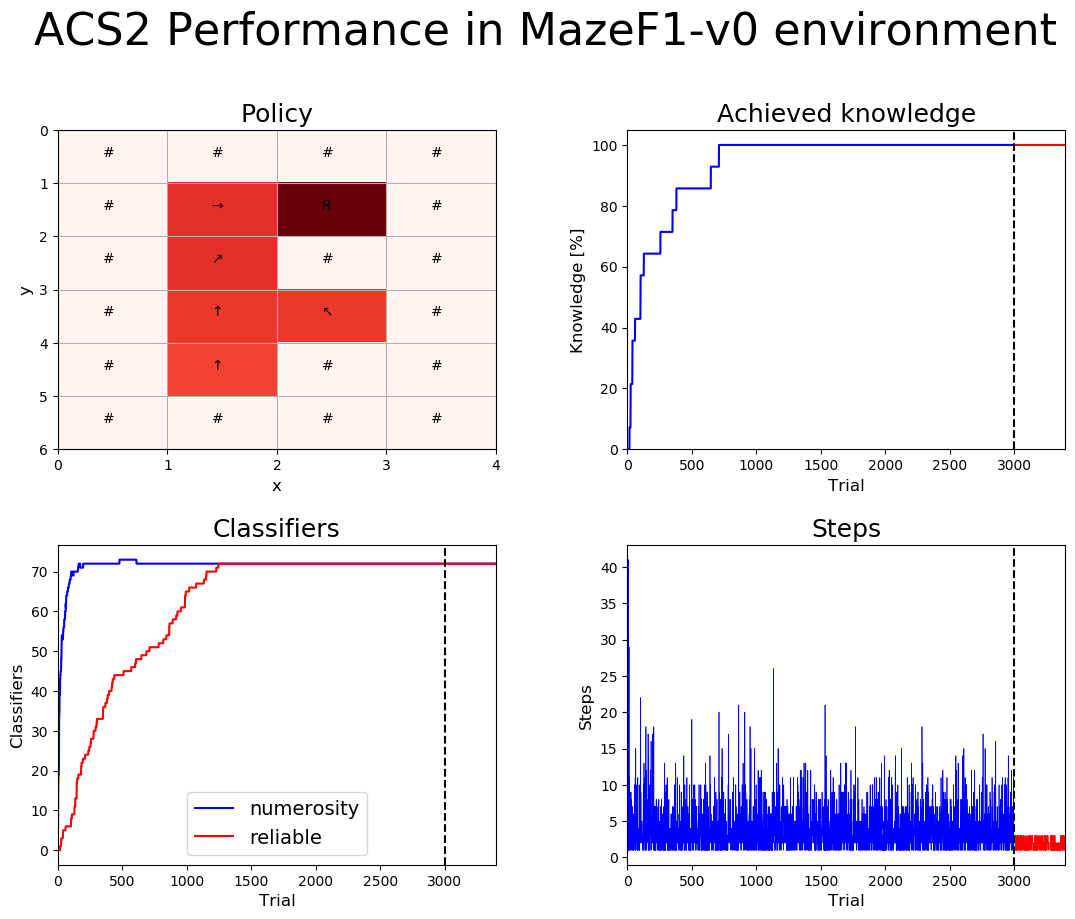

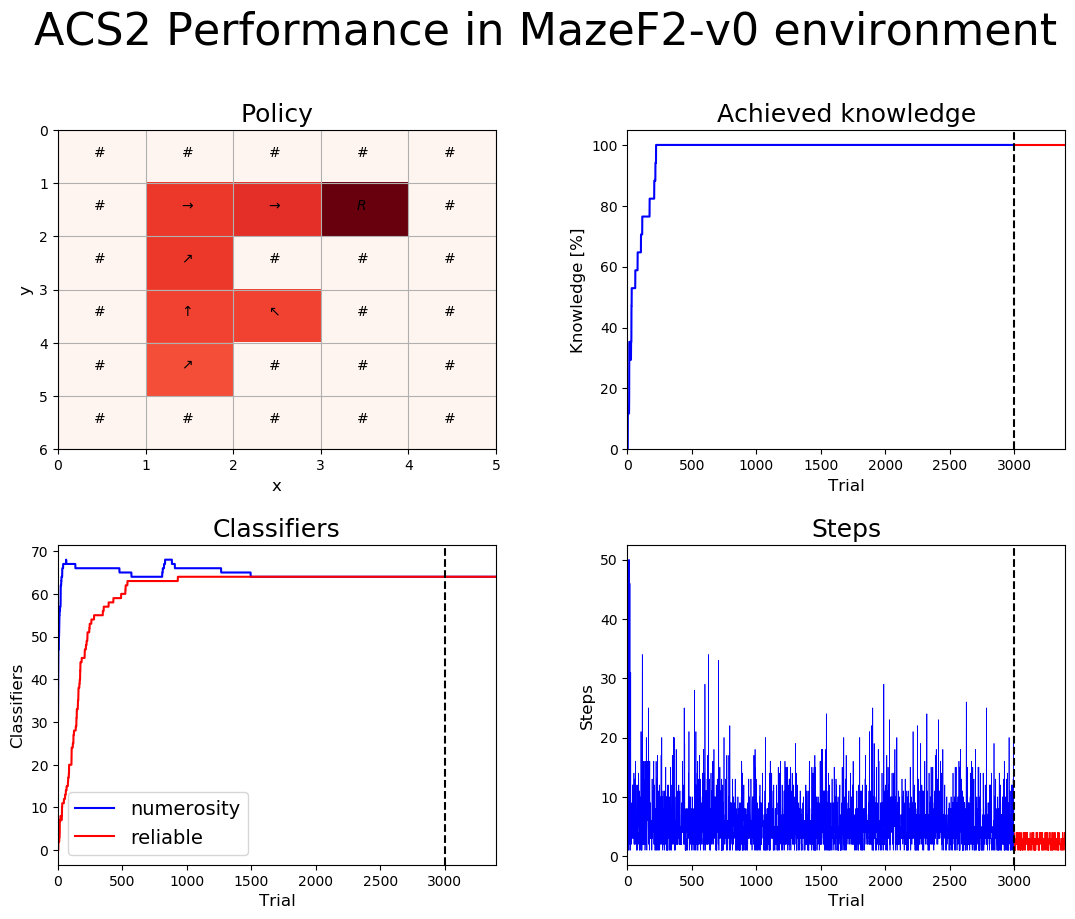

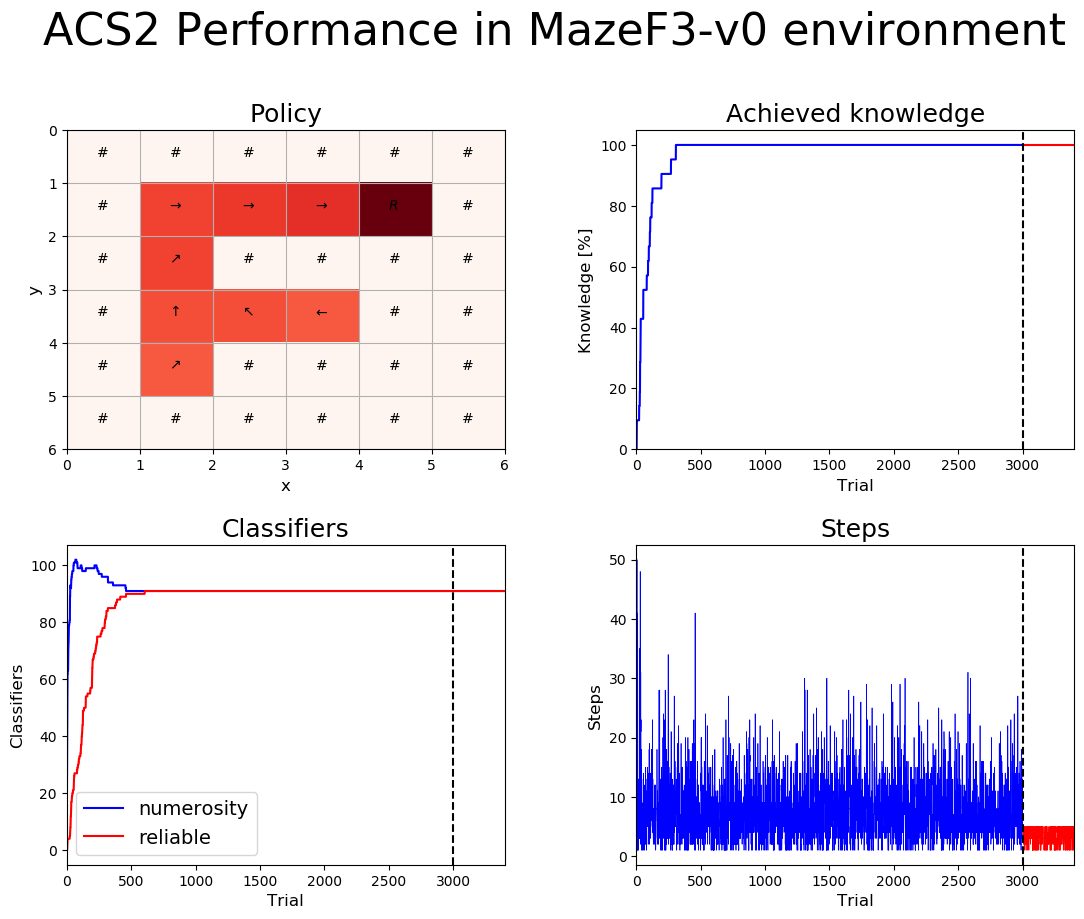

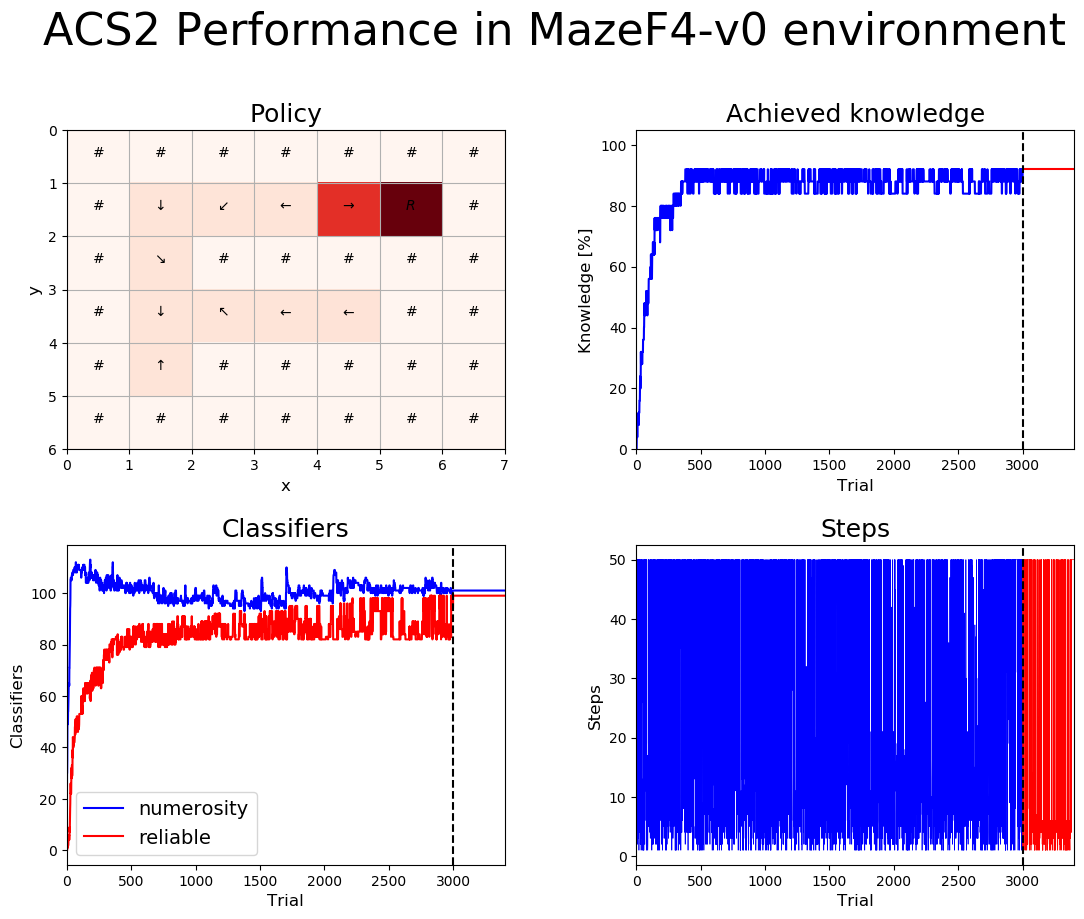

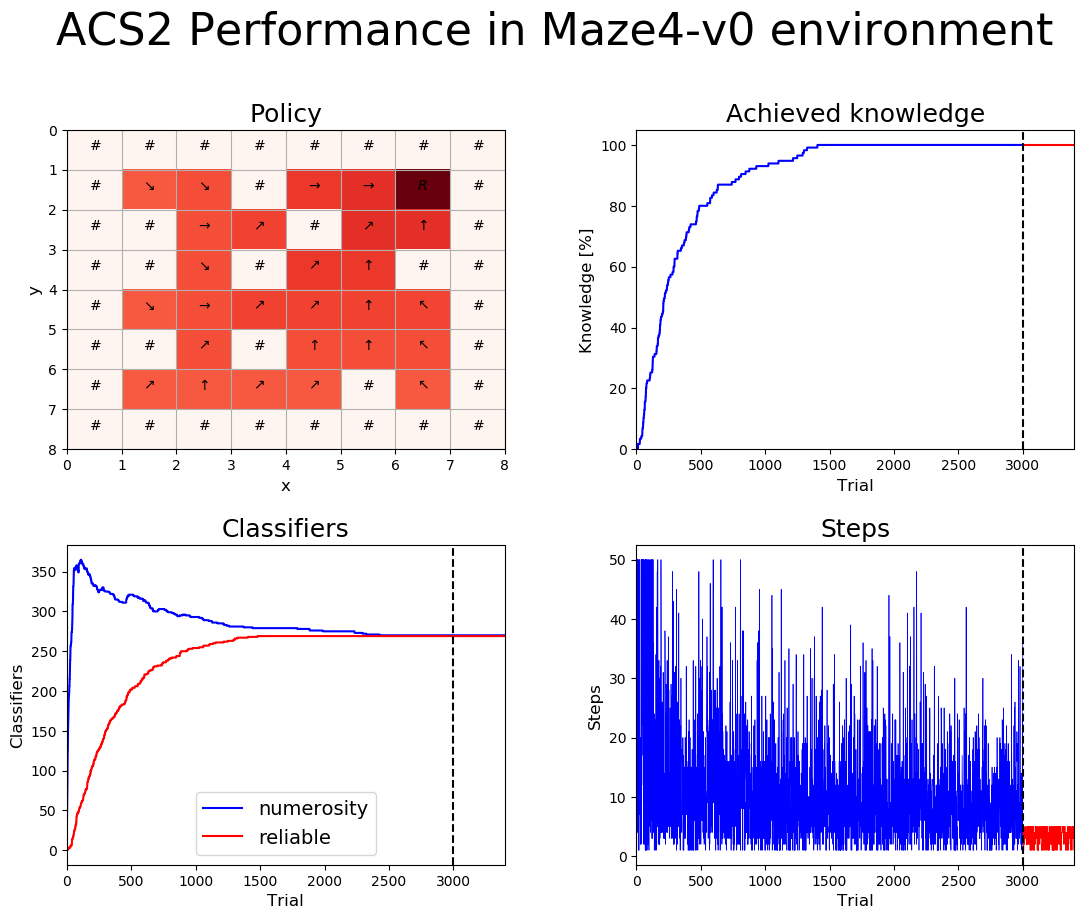

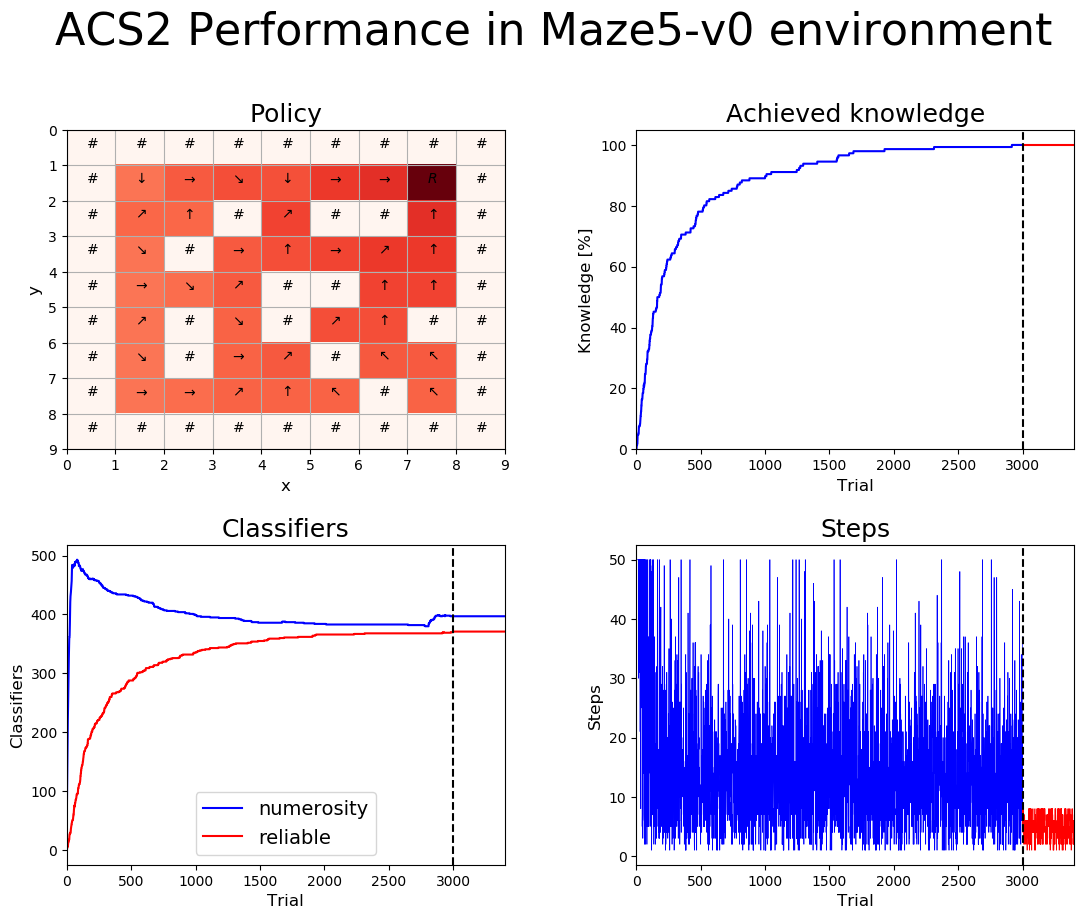

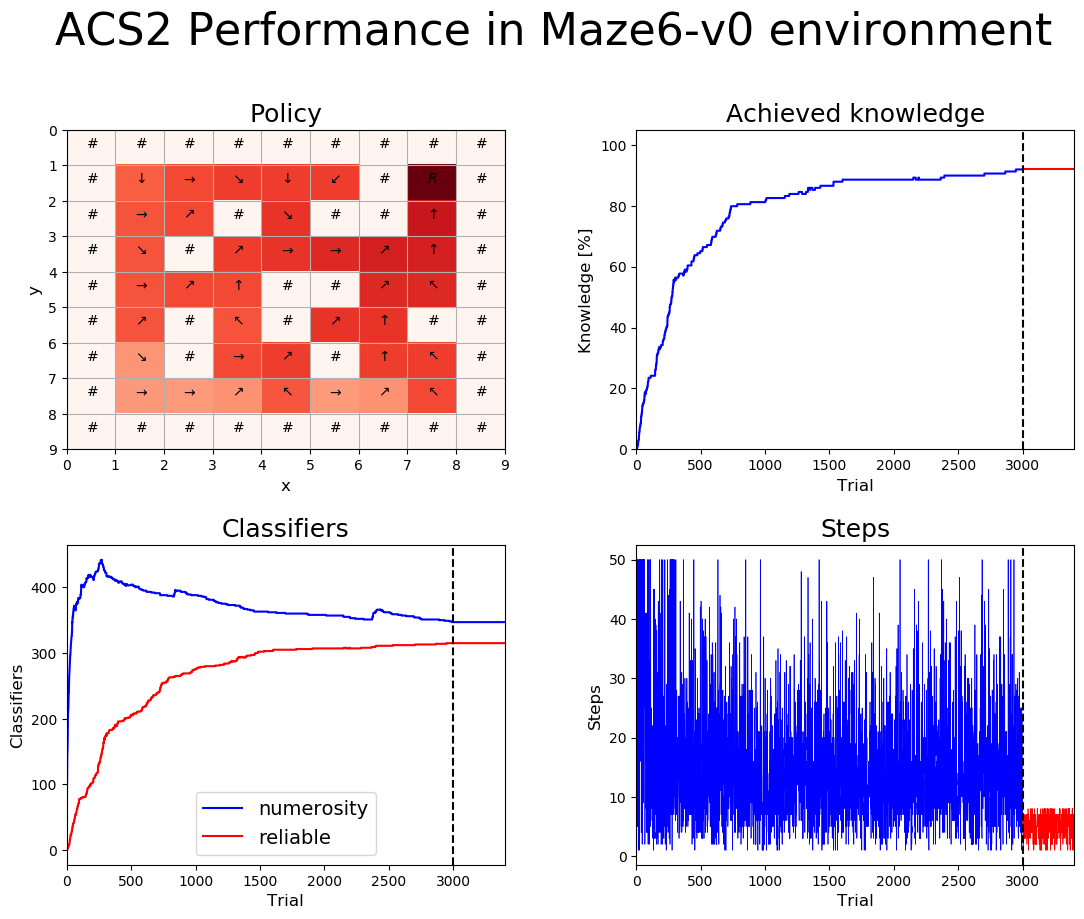

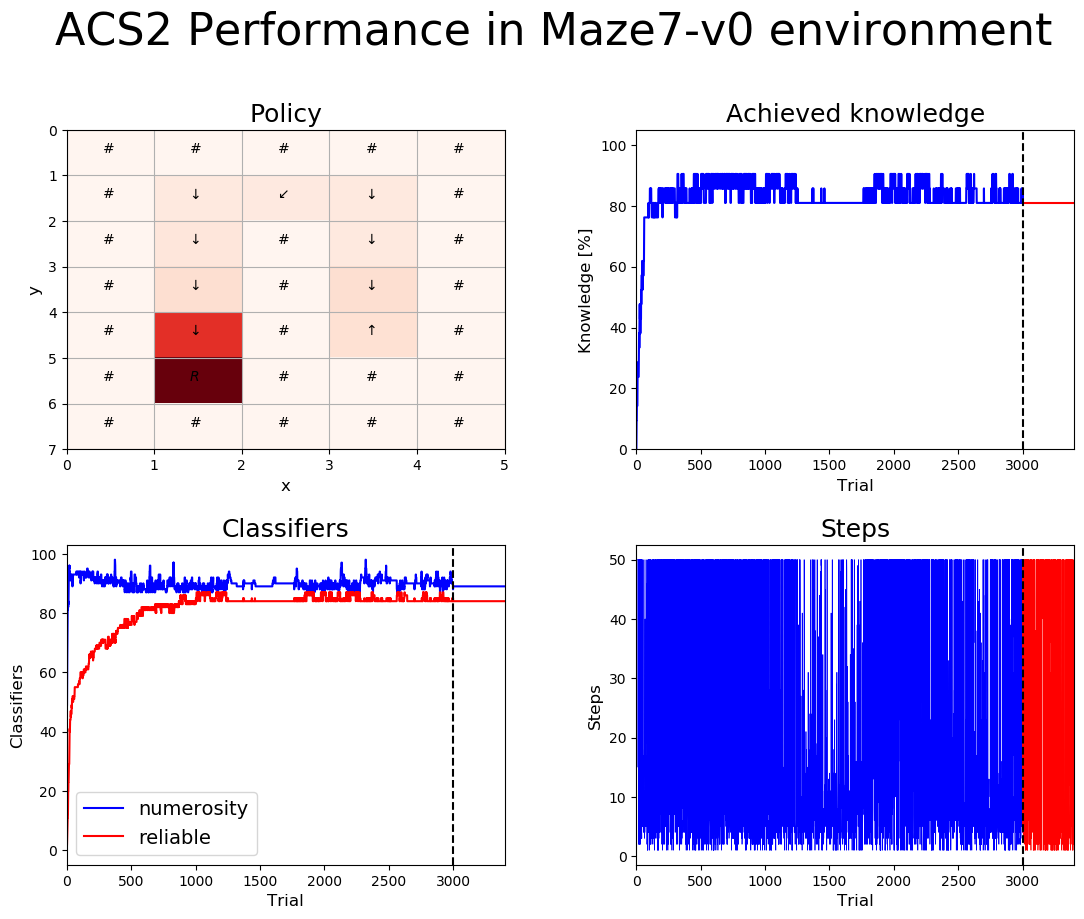

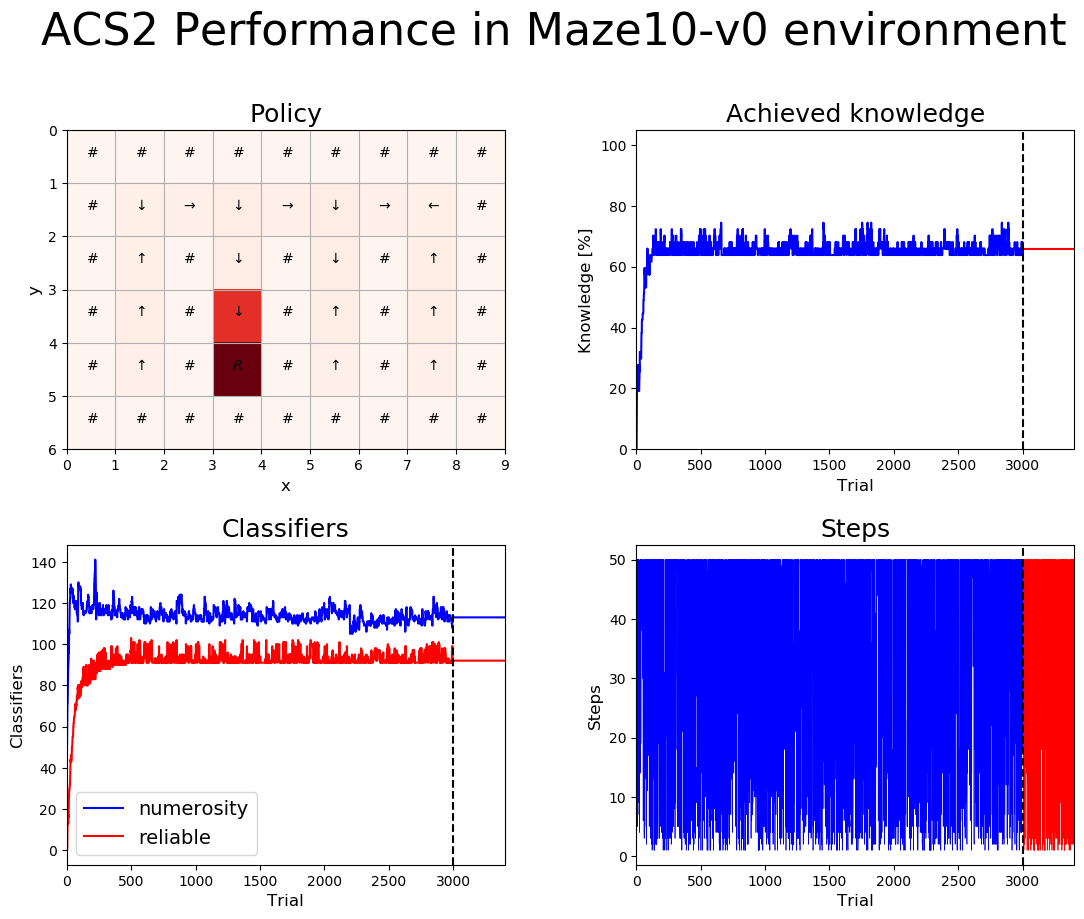

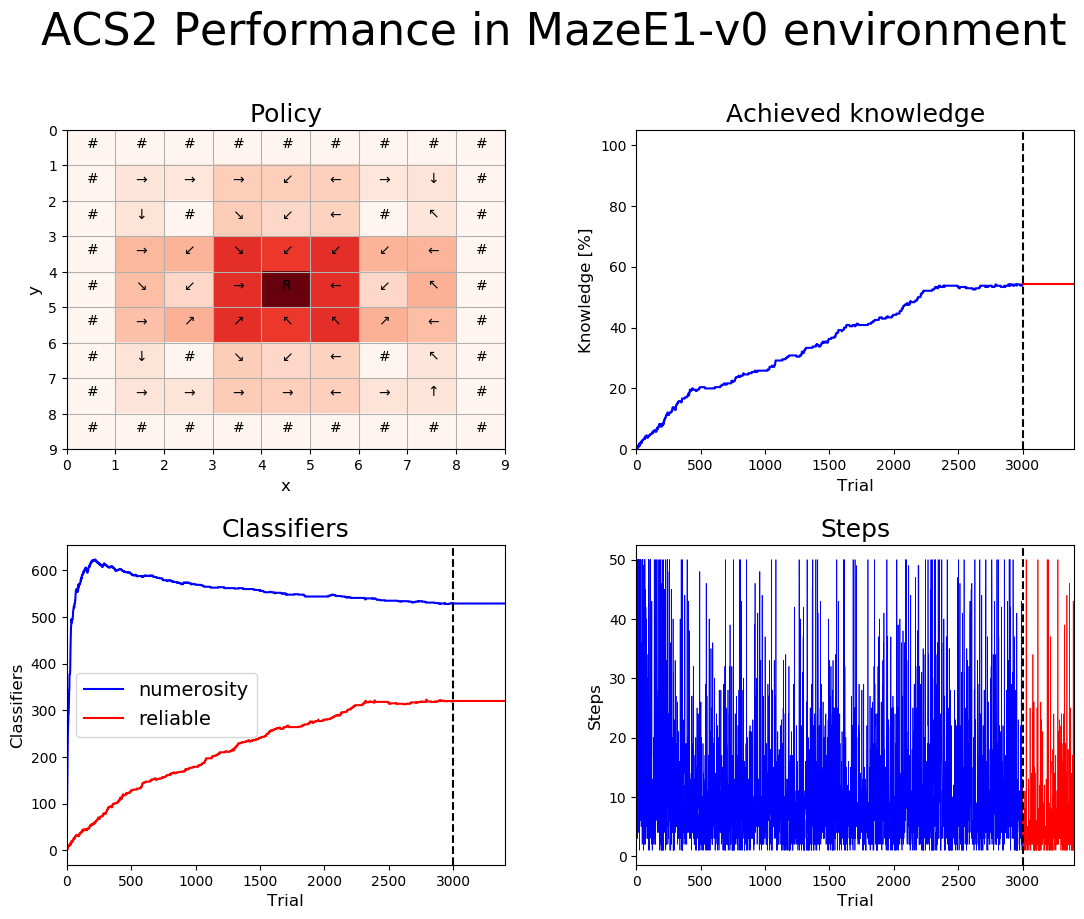

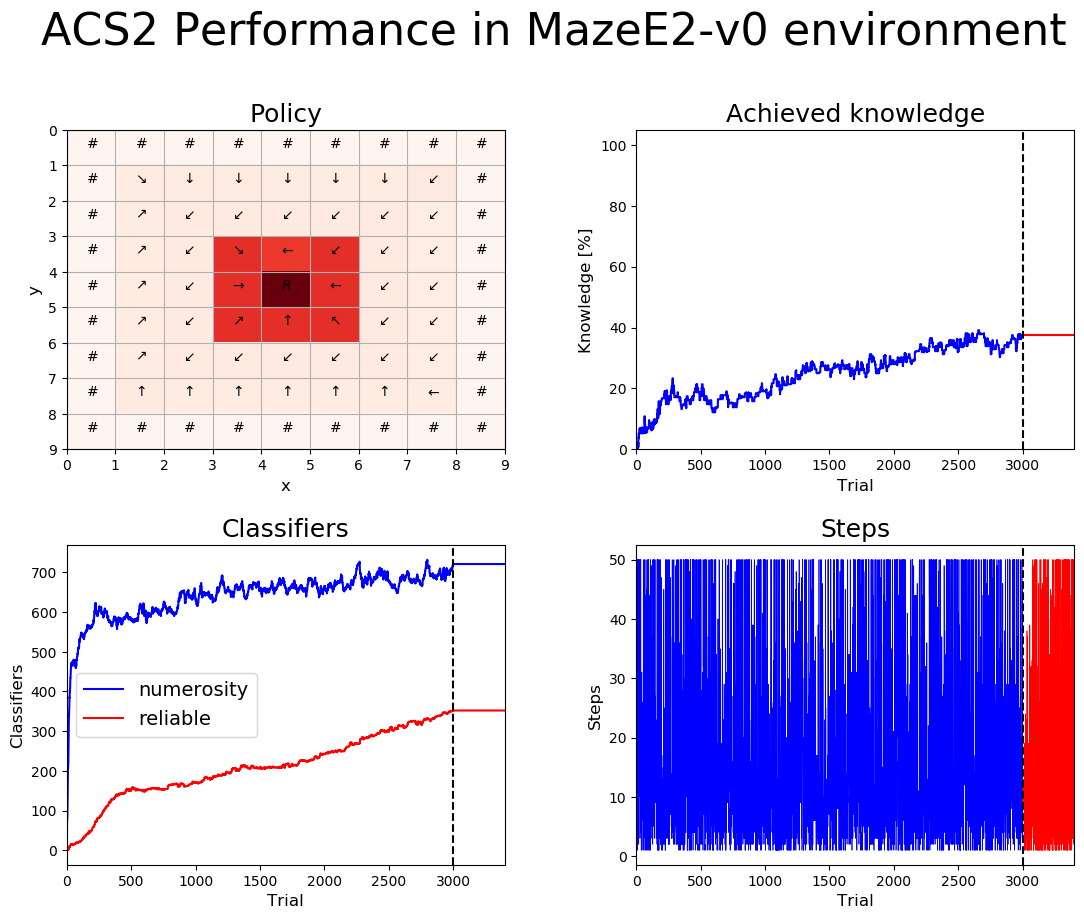

In [23]:
%%time

# Define agent's default configuration
cfg = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=False,
    do_subsumption=True,
    do_action_planning=False,
    action_planning_frequency=50,
    beta=0.05,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.5,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8
)

# Get the accurate environment
filter_envs = lambda env: env.id.startswith("Maze")
all_envs = [env for env in gym.envs.registry.all()]
maze_envs = [env for env in all_envs if filter_envs(env)]

for env in maze_envs:
    # define environement
    maze = gym.make(env.id)
    # explore
    agent_maze = ACS2(cfg)
    population_maze_explore, metrics_maze_explore = agent_maze.explore(maze, 3000)
    # exploit
    agent_maze = ACS2(cfg, population_maze_explore)
    _, metrics_maze_exploit = agent_maze.exploit(maze, 400)
    # plot performance
    maze_metrics_df = parse_metrics_to_df(metrics_maze_explore, metrics_maze_exploit)
    plot_performance(agent_maze, maze, maze_metrics_df, cfg, env.id)


### All Woods

CPU times: user 7min 50s, sys: 382 ms, total: 7min 51s
Wall time: 7min 51s


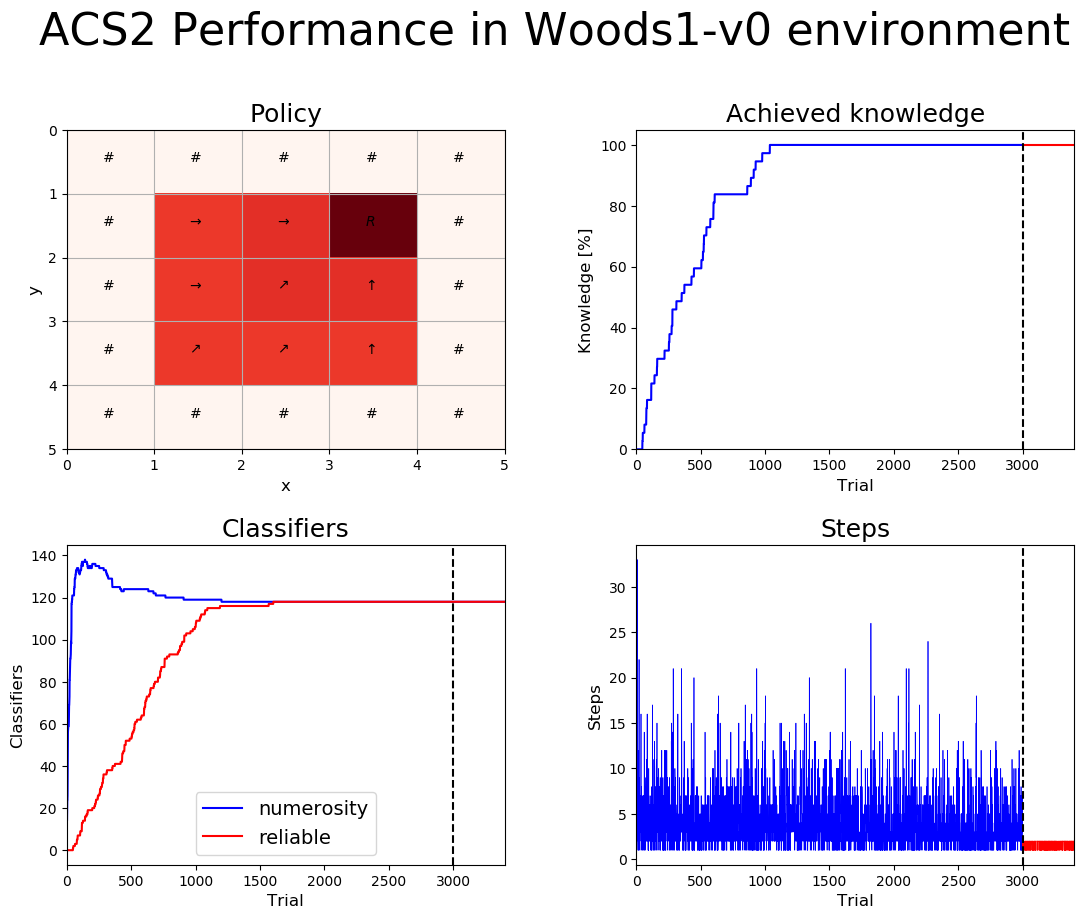

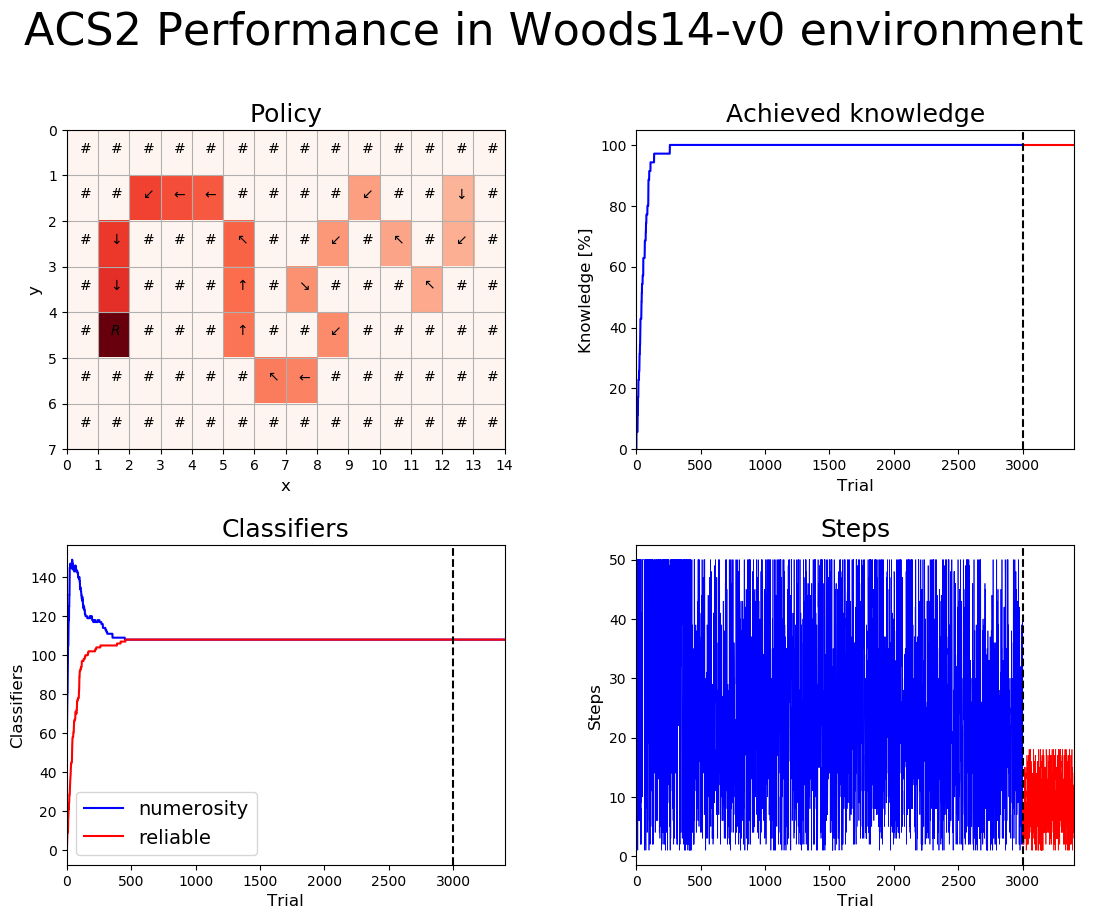

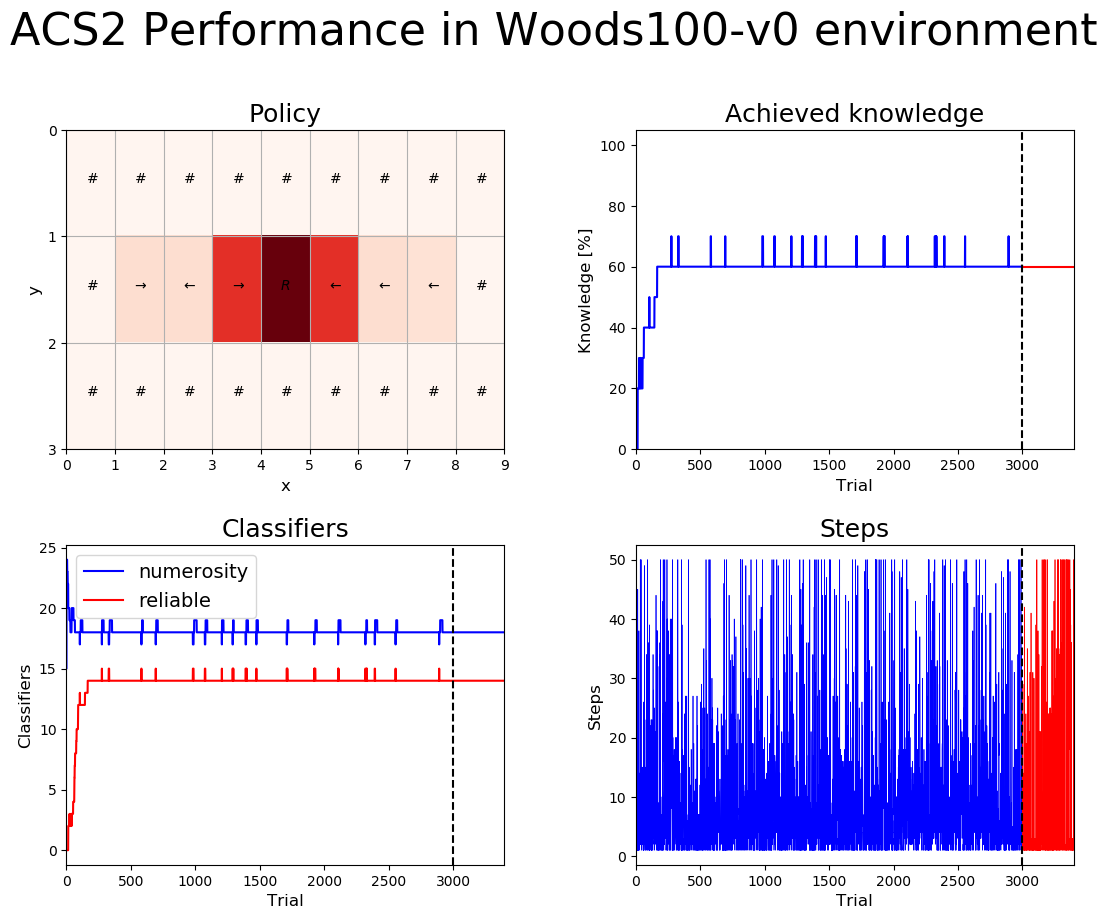

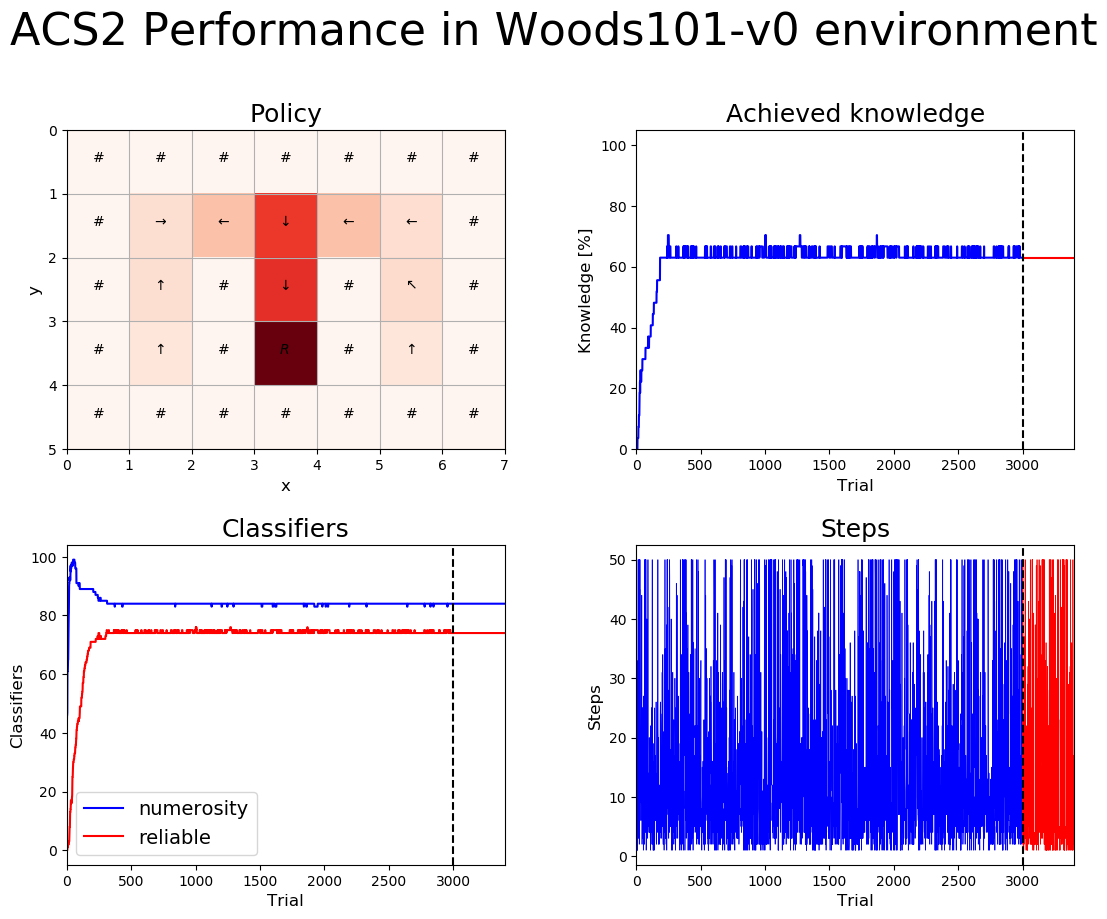

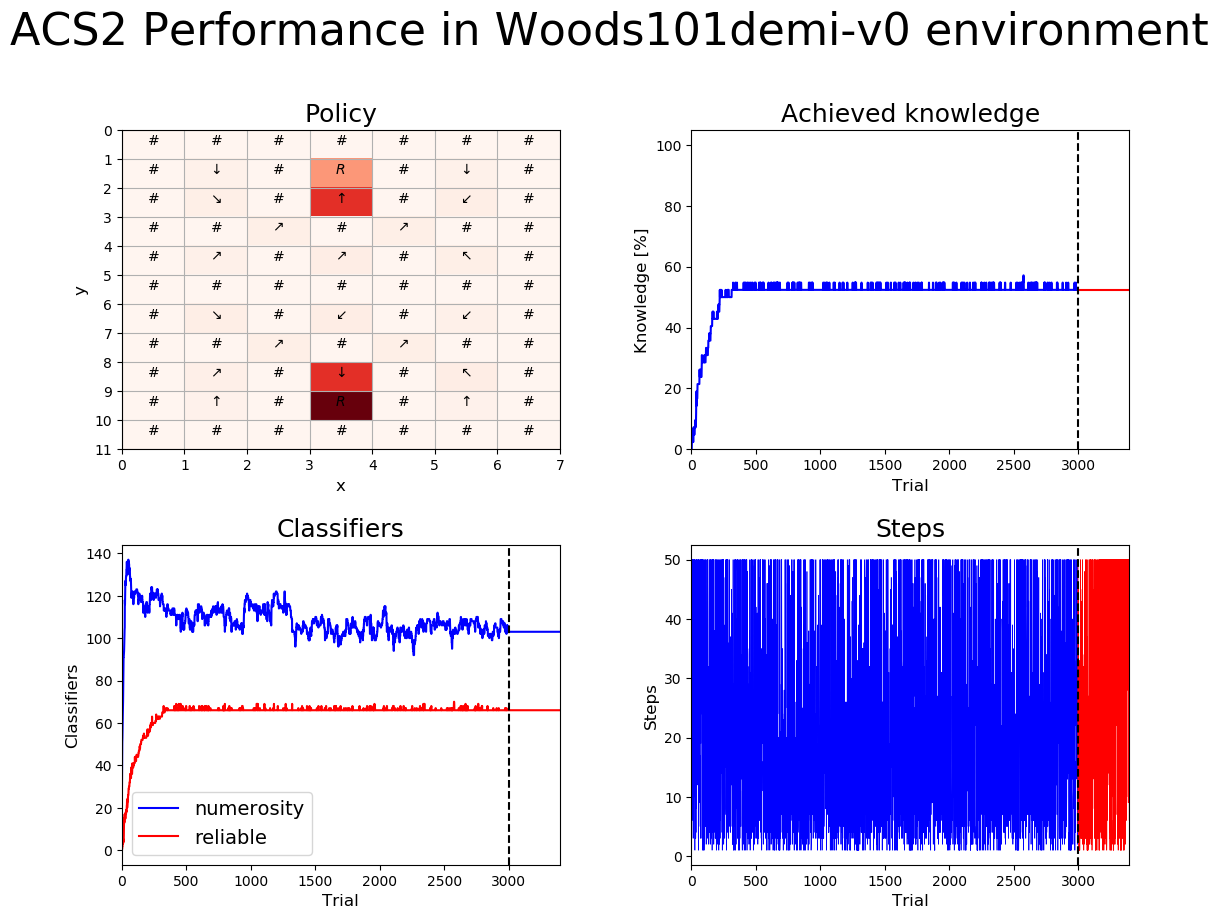

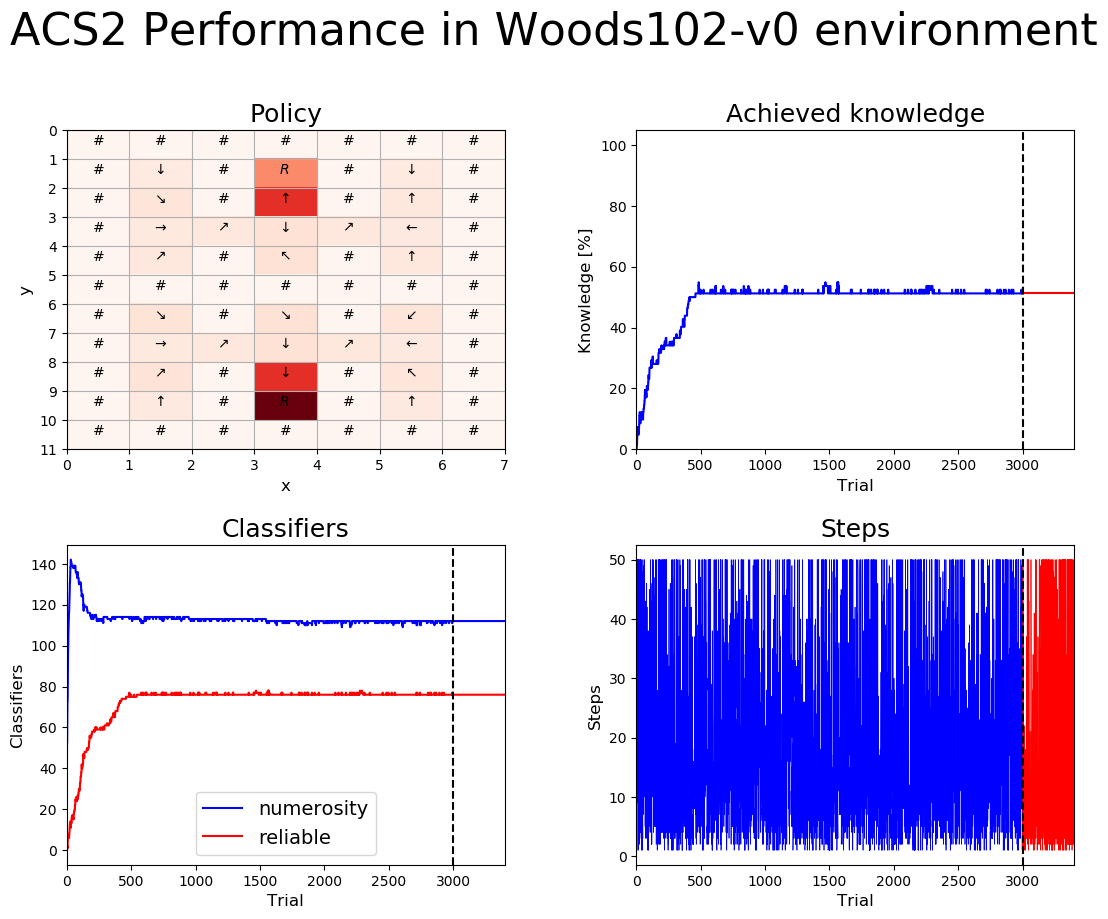

In [24]:
%%time

# Define agent's default configuration
cfg = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=False,
    do_subsumption=True,
    do_action_planning=False,
    action_planning_frequency=50,
    beta=0.05,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.5,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8
)

# Get the accurate environment
filter_envs = lambda env: env.id.startswith("Woods")
all_envs = [env for env in gym.envs.registry.all()]
maze_envs = [env for env in all_envs if filter_envs(env)]

for env in maze_envs:
    # define environement
    maze = gym.make(env.id)
    # explore
    agent_maze = ACS2(cfg)
    population_maze_explore, metrics_maze_explore = agent_maze.explore(maze, 3000)
    # exploit
    agent_maze = ACS2(cfg, population_maze_explore)
    _, metrics_maze_exploit = agent_maze.exploit(maze, 400)
    # plot performance
    maze_metrics_df = parse_metrics_to_df(metrics_maze_explore, metrics_maze_exploit)
    plot_performance(agent_maze, maze, maze_metrics_df, cfg, env.id)


### Littman and Miyazaki

CPU times: user 6min 35s, sys: 287 ms, total: 6min 35s
Wall time: 6min 36s


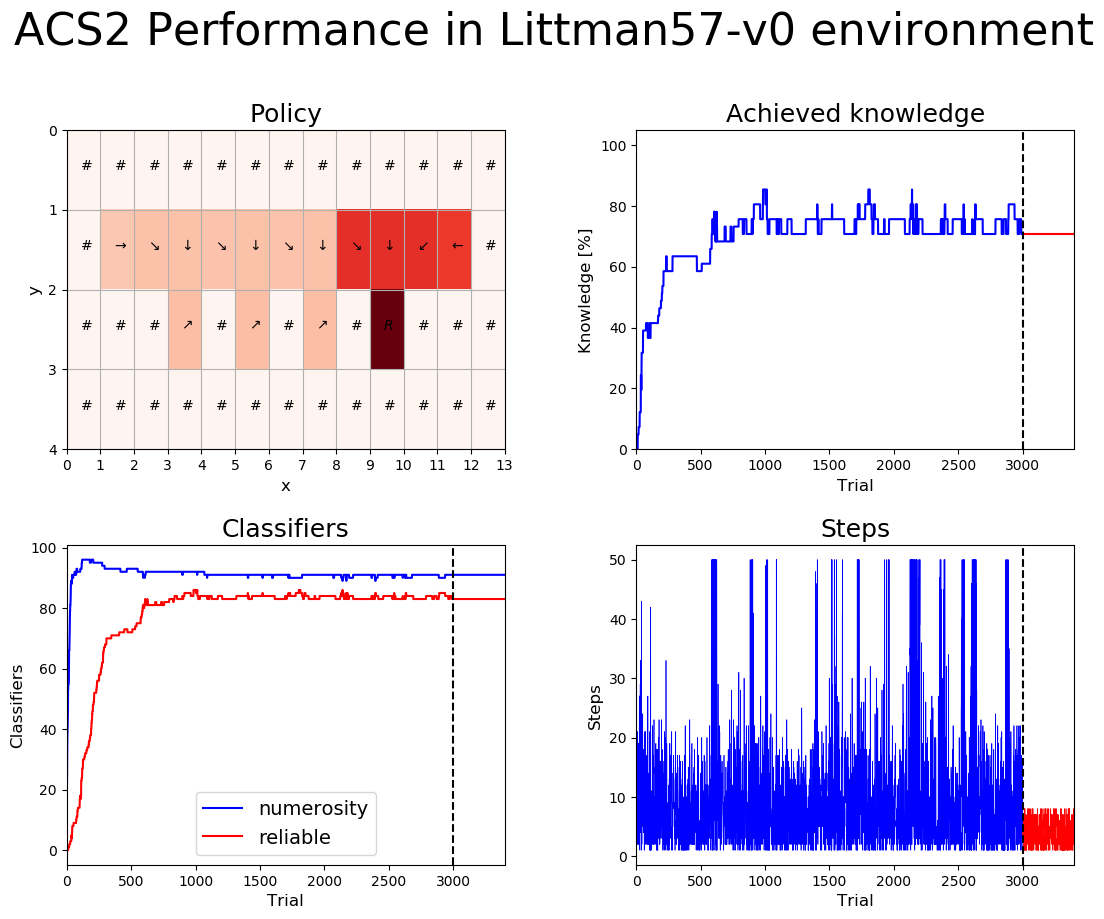

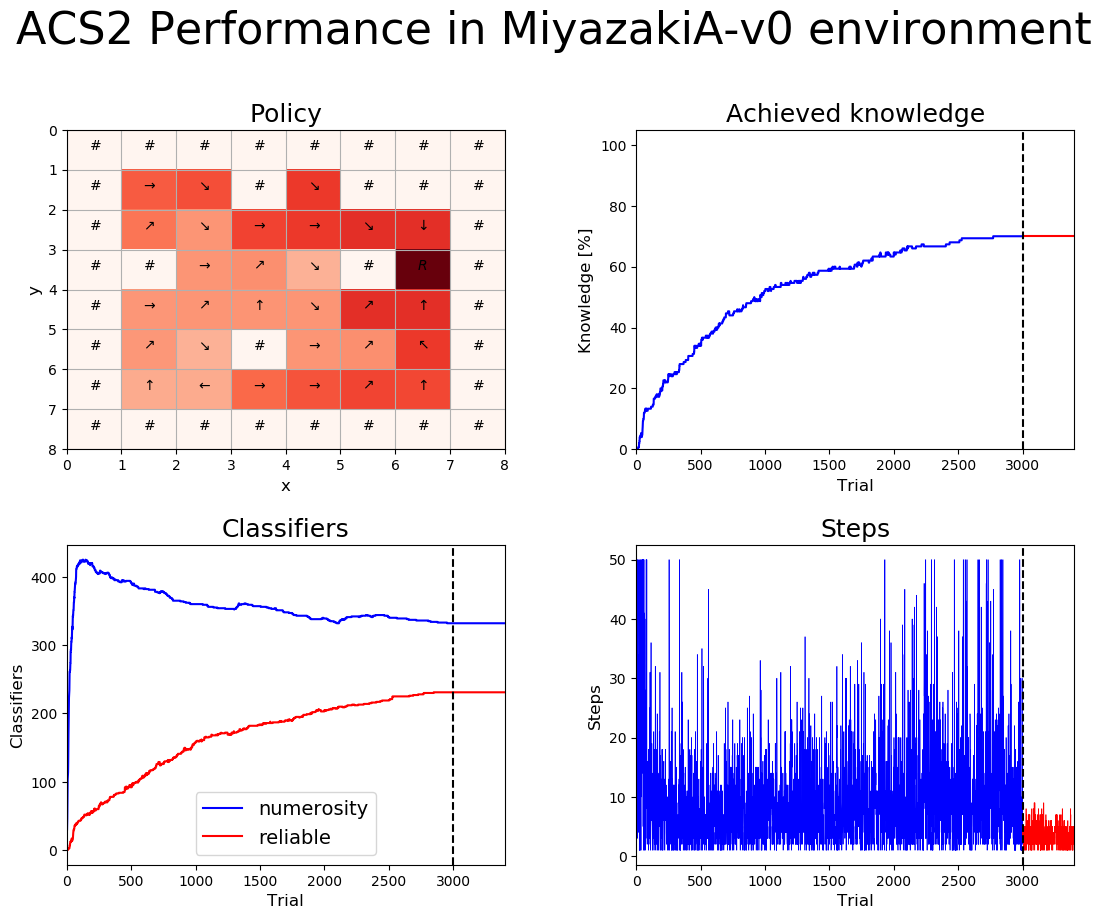

In [25]:
%%time

# Define agent's default configuration
cfg = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=False,
    do_subsumption=True,
    do_action_planning=False,
    action_planning_frequency=50,
    beta=0.05,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.5,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8
)

# Get the accurate environment
filter_envs = lambda env: env.id.startswith("Littman") or env.id.startswith("Miyazaki")
all_envs = [env for env in gym.envs.registry.all()]
maze_envs = [env for env in all_envs if filter_envs(env)]

for env in maze_envs:
    # define environement
    maze = gym.make(env.id)
    # explore
    agent_maze = ACS2(cfg)
    population_maze_explore, metrics_maze_explore = agent_maze.explore(maze, 3000)
    # exploit
    agent_maze = ACS2(cfg, population_maze_explore)
    _, metrics_maze_exploit = agent_maze.exploit(maze, 400)
    # plot performance
    maze_metrics_df = parse_metrics_to_df(metrics_maze_explore, metrics_maze_exploit)
    plot_performance(agent_maze, maze, maze_metrics_df, cfg, env.id)
